# EEGMMIDB — Data Exploration & NeuroGPT Classification

Goal:
- Load the EEGMMIDB motor movement / imagery dataset
- Explore signals and labels
- Classification with NeuroGPT usage

In [4]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# Project paths
PROJECT_ROOT = Path.cwd()
SRC_PATH = PROJECT_ROOT / "src"
DATA_PATH = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

sys.path.append(str(SRC_PATH))

from dataloader import EEGMMIDBDataset

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)

Project root: /home/jovyan/neuro-eeg
Data path: /home/jovyan/neuro-eeg/data/physionet.org/files/eegmmidb/1.0.0


In [5]:
import mne

edf = DATA_PATH / "S001" / "S001R03.edf"
raw = mne.io.read_raw_edf(edf, preload=False, verbose=False)

print(sorted(raw.ch_names))


['Af3.', 'Af4.', 'Af7.', 'Af8.', 'Afz.', 'C1..', 'C2..', 'C3..', 'C4..', 'C5..', 'C6..', 'Cp1.', 'Cp2.', 'Cp3.', 'Cp4.', 'Cp5.', 'Cp6.', 'Cpz.', 'Cz..', 'F1..', 'F2..', 'F3..', 'F4..', 'F5..', 'F6..', 'F7..', 'F8..', 'Fc1.', 'Fc2.', 'Fc3.', 'Fc4.', 'Fc5.', 'Fc6.', 'Fcz.', 'Fp1.', 'Fp2.', 'Fpz.', 'Ft7.', 'Ft8.', 'Fz..', 'Iz..', 'O1..', 'O2..', 'Oz..', 'P1..', 'P2..', 'P3..', 'P4..', 'P5..', 'P6..', 'P7..', 'P8..', 'Po3.', 'Po4.', 'Po7.', 'Po8.', 'Poz.', 'Pz..', 'T10.', 'T7..', 'T8..', 'T9..', 'Tp7.', 'Tp8.']


## Load Dataset for exploration

Subject 1, motor execution + imagery, left/right hand

Classes:
- 0: Right imagined
- 1: Right real
- 2: Left imagined
- 3: Left real

In [6]:
dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=[1],
    runs=[3, 4, 7, 8, 11, 12],
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

print("Total extracted trials:", len(dataset))

Total extracted trials: 90


In [7]:
from collections import Counter

labels = [dataset[i]["labels"].item() for i in range(len(dataset))]

label_map = {
    0: "Right Imagined",
    1: "Right Real",
    2: "Left Imagined",
    3: "Left Real"
}

counts = Counter(labels)

print("Dataset-level class counts:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {counts.get(k, 0)}")


Dataset-level class counts:
Right Imagined : 22
Right Real     : 22
Left Imagined  : 23
Left Real      : 23


In [8]:
import mne
from collections import defaultdict

event_summary = defaultdict(lambda: defaultdict(int))

for run in [3, 4, 7, 8, 11, 12]:
    edf_path = DATA_PATH / "S001" / f"S001R{run:02d}.edf"
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    
    _, event_id = mne.events_from_annotations(raw, verbose=False)
    
    for label in event_id.keys():
        event_code = label.split("/")[-1]
        event_summary[run][event_code] += 1

print("Raw EDF annotation summary (Subject 1):\n")
for run, events in event_summary.items():
    print(f"Run {run}: {dict(events)}")


Raw EDF annotation summary (Subject 1):

Run 3: {'T0': 1, 'T1': 1, 'T2': 1}
Run 4: {'T0': 1, 'T1': 1, 'T2': 1}
Run 7: {'T0': 1, 'T1': 1, 'T2': 1}
Run 8: {'T0': 1, 'T1': 1, 'T2': 1}
Run 11: {'T0': 1, 'T1': 1, 'T2': 1}
Run 12: {'T0': 1, 'T1': 1, 'T2': 1}


In [9]:
print("Sample-wise label sanity check (first 10 trials):\n")

for i in range(10):
    sample = dataset[i]
    label = sample["labels"].item()
    print(f"Trial {i:02d} -> Class {label}: {label_map[label]}")


Sample-wise label sanity check (first 10 trials):

Trial 00 -> Class 1: Right Real
Trial 01 -> Class 3: Left Real
Trial 02 -> Class 3: Left Real
Trial 03 -> Class 1: Right Real
Trial 04 -> Class 1: Right Real
Trial 05 -> Class 3: Left Real
Trial 06 -> Class 3: Left Real
Trial 07 -> Class 1: Right Real
Trial 08 -> Class 3: Left Real
Trial 09 -> Class 1: Right Real


## Visual comparison: Right Imagined vs Right Real EEG signals

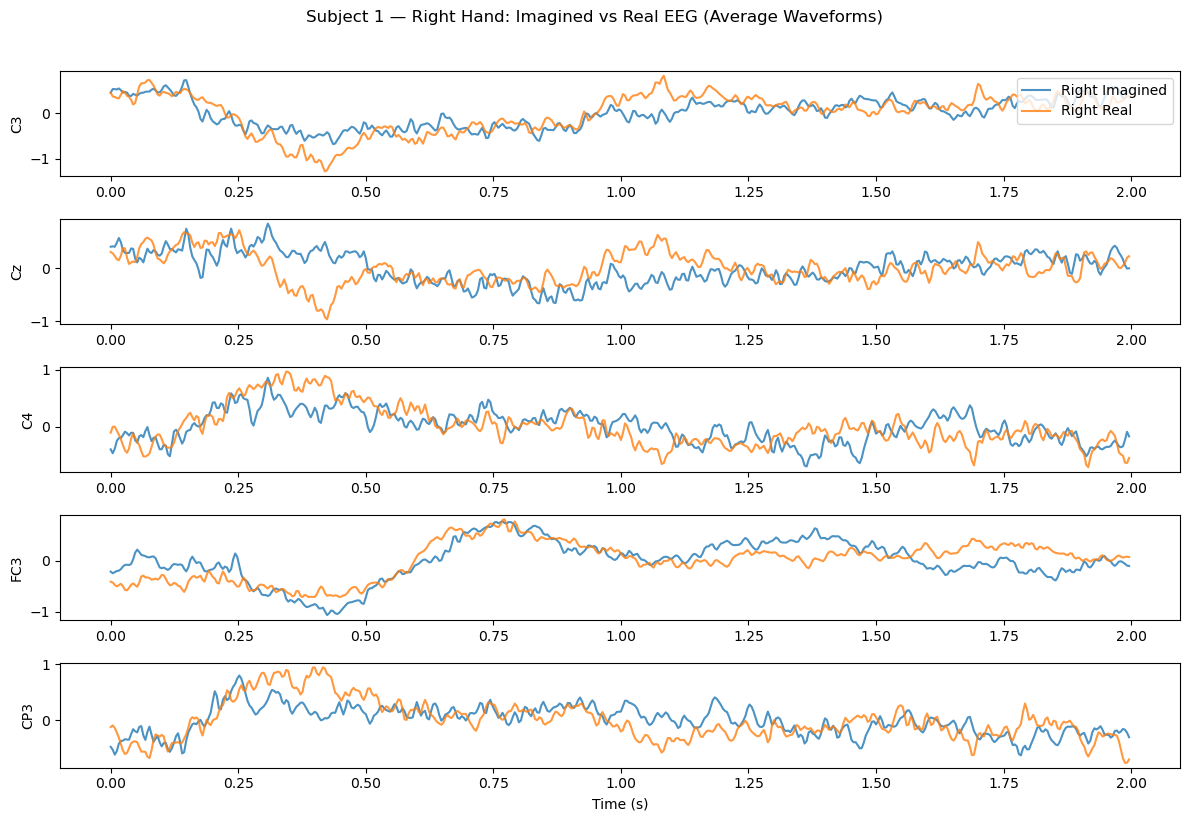

In [10]:
import matplotlib.pyplot as plt

"""
# sample channels
channel_names = [
    "C3", "C4", "Cz", "F3", "F4"
]


neurogpt_channels = [
    "Fp1","Fp2","F7","F3","Fz","F4","F8",
    "T1","T3","C3","Cz","C4","T4","T2",
    "T5","P3","Pz","P4","T6","O1","Oz","O2"
]
"""

# Focus on the Motor Strip (C-line) and surrounding areas
channel_names = [
    "C3",   # Primary Left Motor Cortex (Contralateral to Right Hand - MOST IMPORTANT)
    "Cz",   # Midline Motor Cortex
    "C4",   # Primary Right Motor Cortex (Ipsilateral)
    "FC3",  # Pre-motor area (Left)
    "CP3"   # Somatosensory/Post-central area (Left)
]

neurogpt_channels = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz", 
    "C2", "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz"
]

channel_indices = [neurogpt_channels.index(ch) for ch in channel_names]

# Collect trials
imagined_trials = []
real_trials = []

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()

    # Right Imagined = 0, Right Real = 1
    if label == 0:
        imagined_trials.append(sample["inputs"])
    elif label == 1:
        real_trials.append(sample["inputs"])

# Compute average waveform per class
imagined_avg = torch.stack(imagined_trials).mean(dim=0)
real_avg = torch.stack(real_trials).mean(dim=0)

# Time axis (seconds)
sfreq = 250
time = np.arange(imagined_avg.shape[1]) / sfreq

# Plot
plt.figure(figsize=(12, 8))

for i, ch_idx in enumerate(channel_indices):
    plt.subplot(len(channel_indices), 1, i + 1)
    plt.plot(time, imagined_avg[ch_idx].numpy(), label="Right Imagined", alpha=0.8)
    plt.plot(time, real_avg[ch_idx].numpy(), label="Right Real", alpha=0.8)
    plt.ylabel(channel_names[i])
    if i == 0:
        plt.legend(loc="upper right")

plt.xlabel("Time (s)")
plt.suptitle("Subject 1 — Right Hand: Imagined vs Real EEG (Average Waveforms)", y=1.02)
plt.tight_layout()
plt.show()


In [11]:
import numpy as np

energy_by_class = defaultdict(list)

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()
    energy = sample["inputs"].pow(2).mean().item()
    energy_by_class[label].append(energy)

print("Mean signal energy per class:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {np.mean(energy_by_class[k]):.4f}")


Mean signal energy per class:
Right Imagined : 0.9163
Right Real     : 0.9236
Left Imagined  : 0.9129
Left Real      : 0.9253


## NeuroGPT Teaser

Each trial is already:
- 22-channel (NeuroGPT format)
- Normalized
- Fixed-length
- Labeled

In [12]:
batch = dataset[0]
print(batch["inputs"].shape)
print(batch["labels"].item())


torch.Size([22, 500])
1


## Loading the train, test data

In [13]:
all_subjects = list(range(1, 109))  # subject range
print("Subjects:", all_subjects)

MI_ME_RUNS = [3, 4, 7, 8, 11, 12]
print("MI_ME runs:", MI_ME_RUNS)

Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
MI_ME runs: [3, 4, 7, 8, 11, 12]


In [14]:
# create folds

train_folds = []
test_folds = []

for i in range(len(all_subjects) // 2):
    test_subjects = all_subjects[i*2 : i*2+2]
    train_subjects = all_subjects[:i*2] + all_subjects[i*2+2:]

    train_folds.append(train_subjects)
    test_folds.append(test_subjects)


In [15]:
from dataloader import EEGMMIDBDataset

train_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=train_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

test_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=test_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

# Simple setup (same as your example)
validation_dataset = test_dataset

/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/neuro-eeg/src/dataloader.py:143: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/ne

In [16]:
print("Train trials:", len(train_dataset))
print("Test trials :", len(test_dataset))

batch = train_dataset[0]
print("Input shape:", batch["inputs"].shape)   # (22, T)
print("Label:", batch["labels"].item())


Train trials: 9575
Test trials : 180
Input shape: torch.Size([22, 500])
Label: 1


## Model

In [17]:
import os
import sys
import json
home = os.environ["HOME"]
python_imports = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder"
cache_root = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/"
sys.path.append(python_imports)

with open(os.path.join(python_imports,"NeuroGPT_mini/config.json"), "r", encoding="utf-8") as f:
    config = json.load(f)

In [18]:
import numpy as np
import torch
import os
import sys 
sys.path.insert(0,os.path.join(python_imports,'NeuroGPT_mini/') )
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score
import random
import json

### Import related to Transformer model (from files located in /NeuroGPT directory)

from encoder.conformer_braindecode import EEGConformer
from decoder.make_decoder import make_decoder
from embedder.make import make_embedder
from trainer.make import make_trainer
from trainer.base import Trainer
from decoder.unembedder import make_unembedder
import pandas as pd
from typing import Dict

import matplotlib.pyplot as plt

2026-01-24 12:31:04.777694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/micromamba/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/micromamba/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  w

ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
class Model(torch.nn.Module):
    """
    Create Model object from embedder, decoder,
    and unembedder (if not None).

    Args
    ----
    embedder: src.embedder.make_embedder
        Instance of embedder class.
    decoder: src.decoder.make_decoder
        Instance of decoder class.
    unembedder: src.unembedder.make_unembedder
        Instance of unembedder class.
        Only added to model if not None.

    Methods
    ----
    forward(batch: Dict[str, torch.tensor])
        Forward pass of model.
    prep_batch(batch: Dict[str, torch.tensor])
        Prepare batch for forward pass.
    compute_loss(batch: Dict[str, torch.tensor])
        Compute training loss.
    from_pretrained(pretrained_path: str)
        Load pretrained model from pretrained_path.
        Needs to point to pytorch_model.bin file 
    """
    def __init__(
        self,
        encoder: torch.nn.Module,
        embedder: torch.nn.Module,
        decoder: torch.nn.Module,
        unembedder: torch.nn.Module = None
        ) -> torch.nn.Module:
        
        super().__init__()
        self.name = f'Embedder-{embedder.name}_Decoder-{decoder.name}'
        self.encoder = encoder
        self.embedder = embedder
        self.decoder = decoder
        self.unembedder = unembedder
        self.is_decoding_mode = False
        self.ft_only_encoder = False

    def from_pretrained(
        self,
        pretrained_path: str
        ) -> None:
        """Load pretrained model from pretrained_path.
        Needs to point to pytorch_model.bin file.
        """
        print(
            f'Loading pretrained model from {pretrained_path}'
        )

        if next(self.parameters()).is_cuda:
            pretrained = torch.load(pretrained_path)

        else:
            pretrained = torch.load(pretrained_path, map_location=torch.device('cpu'))
        
        for k in self.state_dict():
            
            if k in pretrained:
                assert pretrained[k].shape == self.state_dict()[k].shape,\
                    f'{k} shape mismatch between pretrained model and current model '+\
                    f'{pretrained[k].shape} vs {self.state_dict()[k].shape}'
        
        for k in pretrained:     
            if k not in self.state_dict():
                warnings.warn(
                    f'Warning: /!\ Skipping {k} from {pretrained_path} '\
                    'because it is not part of the current model'
                )

        # we set strict=False, because we can be sure
        # that all relevant keys are in pretrained
        self.load_state_dict(pretrained, strict=False)
        
    def switch_ft_mode(self, ft_encoder_only=False):
        self.ft_only_encoder = ft_encoder_only

    def switch_decoding_mode(
        self,
        is_decoding_mode: bool = False,
        num_decoding_classes: int = None
        ) -> None:
        """Switch model to decoding model or back to training mode.
        Necessary to adapt pre-trained models to downstream
        decoding tasks.
        
        Args
        ----
        is_decoding_mode: bool
            Whether to switch to decoding mode or not.
        num_decoding_classes: int
            Number of classes to use for decoding.    
        """
        self.is_decoding_mode = is_decoding_mode
        
        self.embedder.switch_decoding_mode(is_decoding_mode=is_decoding_mode)
        self.decoder.switch_decoding_mode(
            is_decoding_mode=is_decoding_mode,
            num_decoding_classes=num_decoding_classes
        )

    def compute_loss(
        self,
        batch: Dict[str, torch.tensor],
        return_outputs: bool = False
        ) -> Dict[str, torch.tensor]:
        """
        Compute training loss, based on 
        embedder's training-style.

        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        return_outputs: bool
            Whether to return outputs of forward pass
            or not. If False, only loss is returned.

        Returns
        ----
        losses: Dict[str, torch.tensor]
            Training losses.
        outputs: torch.tensor
            Outputs of forward pass.
        """
        (outputs, batch) = self.forward(
            batch=batch,
            return_batch=True
        )
        losses = self.embedder.loss(
            batch=batch,
            outputs=outputs
        )

        return (losses, outputs) if return_outputs else losses

    def prep_batch(
        self,
        batch: Dict[str, torch.tensor]
        ) -> Dict[str, torch.tensor]:
        """Prepare input batch for forward pass.
        Calls src.embedder.prep_batch.
        
        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        """
        return self.embedder.prep_batch(batch=dict(batch))

    def forward(
        self,
        batch: Dict[str, torch.tensor],
        prep_batch: bool = True,
        return_batch: bool = False
        ) -> torch.tensor:
        """
        Forward pass of model.
        
        Args
        ----
        batch: Dict[str, torch.tensor]
            Input batch (as generated by src.batcher)
        prep_batch: bool
            Whether to prep batch for forward pass
            by calling self.embedder.prep_batch
        return_batch: bool
            Whether to return batch after forward pass
            or not. If False, only outputs of forward pass
            are returned.

        Returns
        ----
        outputs: torch.tensor
            Outputs of forward pass.
        batch: Dict[str, torch.tensor]
            Input batch (as returned by prep_batch, 
            if prep_batch is True)
        """
        
        if self.encoder is not None:
            #before prep_batch masking and things, we need to first let the splitted chunks of raw input through the encoder
            features = self.encoder(batch['inputs'])
            #attempt for trying fine-tune only the encoder, but the encoder cannot combine information across chunks.
            if self.is_decoding_mode and self.ft_only_encoder:
                outputs={'outputs': features, 'decoding_logits': features}
                return (outputs, batch) if return_batch else outputs

            b, f1, f2 = features.size()
            nchunks = batch['inputs'].size()[1]
            batch['inputs'] = features.view(b//nchunks, nchunks, f1*f2)
        
        if prep_batch:
            if len(batch['inputs'].size()) > 3:
                bsize, chunk, chann, time = batch['inputs'].size() 
                batch['inputs'] = batch['inputs'].view(bsize, chunk, chann*time)
            batch = self.prep_batch(batch=batch)
            # batch['inputs_embeds'] = batch['inputs_embeds'].view(bsize, chunk, chann, time)
            # print("preparing batch")
        else:
            assert 'inputs_embeds' in batch, 'inputs_embeds not in batch'

        # pdb.set_trace()
        batch['inputs_embeds'] = self.embedder(batch=batch)
        outputs = self.decoder(batch=batch)
        
        if self.unembedder is not None and not self.is_decoding_mode:
            outputs['outputs'] = self.unembedder(inputs=outputs['outputs'])['outputs']

        return (outputs, batch) if return_batch else outputs

In [ ]:
def make_model(model_config) : 
# Generate the model
    
    
    ## Encoder
    
    if model_config["use_encoder"] == True:
        
        chann_coords = None
        encoder = EEGConformer(n_outputs=model_config["num_decoding_classes"], n_chans=22, n_times=model_config['chunk_len'], ch_pos=chann_coords, is_decoding_mode=model_config["ft_only_encoder"])
        #calculates the output dimension of the encoder, which is the output of transformer layer.
        model_config["parcellation_dim"] = ((model_config['chunk_len'] - model_config['filter_time_length'] + 1 - model_config['pool_time_length']) // model_config['stride_avg_pool'] + 1) * model_config['n_filters_time']

    else:
        encoder = None
        model_config["parcellation_dim"] = model_config["chunk_len"] * 22
    
    ## Embedder
    
    embedder = make_embedder(
        training_style=model_config["training_style"],
        architecture=model_config["architecture"],
        in_dim=model_config["parcellation_dim"], # flattened, channel x chunk length
        embed_dim=model_config["embedding_dim"],
        num_hidden_layers=model_config["num_hidden_layers_embedding_model"],
        dropout=model_config["dropout"],
        n_positions=model_config["n_positions"]
    )
    
    ## Decoder
    decoder = make_decoder(
        architecture=model_config["architecture"],
        num_hidden_layers=model_config["num_hidden_layers"],
        embed_dim=model_config["embedding_dim"],
        num_attention_heads=model_config["num_attention_heads"],
        n_positions=model_config["n_positions"],
        intermediate_dim_factor=model_config["intermediate_dim_factor"],
        hidden_activation=model_config["hidden_activation"],
        dropout=model_config["dropout"]
    )
   
    
    if model_config["embedding_dim"] != model_config["parcellation_dim"]:
        unembedder = make_unembedder(
            embed_dim=model_config["embedding_dim"],
            num_hidden_layers=model_config["num_hidden_layers_unembedding_model"],
            out_dim=model_config["parcellation_dim"],
            dropout=model_config["dropout"],
        )
    else:
        print("No Embedder and Unembedder!")
        unembedder = None
    
    
    
    model = Model(
        encoder=encoder,
        embedder=embedder,
        decoder=decoder,
        unembedder=unembedder
    )
    
    if model_config["ft_only_encoder"]:
        model.switch_ft_mode(ft_encoder_only=True)
    
    if model_config["training_style"] == 'decoding':
        model.switch_decoding_mode(
            is_decoding_mode=True,
            num_decoding_classes=model_config["num_decoding_classes"]
        )
    
    if model_config["pretrained_model"] is not None:
        model.from_pretrained(model_config["pretrained_model"])
    
    if model_config["freeze_embedder"]:
        for param in model.embedder.parameters():
            param.requires_grad = False
    
    if model_config["freeze_decoder"]:

        ## TO DO : freeze the parameters of the decoder module :
        for param in model.decoder.parameters():
            param.requires_grad = False
            
    if model_config["freeze_encoder"]:
        for name, param in model.encoder.named_parameters():
            if 'fc.' in name \
            or 'final_layer' in name:
                continue
            else:
                param.requires_grad = False
        print('Frozen Encoder : Only the two last layers will be trained')
    
    if 'freeze_decoder_without_pooler_heads' in model_config \
        and model_config["freeze_decoder_without_pooler_heads"]:
        for name, param in model.decoder.named_parameters():
            if 'pooler_layer' in name \
            or 'decoding_head' in name \
            or 'is_next_head' in name:
    

                continue
            else:
                param.requires_grad = False
    
    if model_config["freeze_unembedder"] and unembedder is not None:
        for param in model.unembedder.parameters():
            param.requires_grad = False
    return model

In [ ]:
config_path = {"dst_data_path" : os.path.join(python_imports, "bciiv2a_eeg_npz/"),
         "pretrained_model" : os.path.join(python_imports, "NeuroGPT_mini/pytorch_model.bin"), 
         "log_dir" :os.path.join(python_imports,"training_logs/")}

model_config = config

## Some important parameters in the architecture of the model 

model_config['pretrained_model'] = config_path['pretrained_model'] # Path to the file containing pretrained weights of the model, if model_config['pretrained_model'] = None the model is not pretrained
model_config['embedding_dim'] = 1024 # Dimension of the latent representations in the model
model_config['num_hidden_layers_embedding_model']= 1 # Number of hidden layers in the GPT model 
model_config['num_hidden_layers_unembedding_model']= 1 # Number of hidden layers on the unembedding module 
model_config['num_hidden_layers']= 6  #Number of hidden layers in the encoder module
model_config['filter_time_length']= 25 #Size of the kernel of the temporal convolution layer 
model_config['stride_avg_pool']= 15  # Stride size used in the average-pooling operation
model_config["freeze_encoder"] = False # Whether to freeze the encoder (True = no training on encoder parameters, only the classification layer)


model = make_model(model_config)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# We use a batch size of 16 or 32 depending on your GPU/RAM
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set to evaluation mode

In [ ]:
all_preds = []
all_labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Classifying PhysioNet Data"):
        inputs = batch["inputs"].to(device).float() # Shape: [Batch, 22, 500]
        labels = batch["labels"].to(device)
        
        # 1. Add 'Chunk' dimension -> [Batch, 1, 22, 500]
        inputs = inputs.unsqueeze(1)

        # 2. DUPLICATE BATCH: Counteract the model's internal x.size(0)//2 
        # This turns 16 trials into 32, which the model halves back to 16.
        inputs = torch.repeat_interleave(inputs, 2, dim=0)

        # 3. Forward pass
        outputs = model({"inputs": inputs})
        
        # 4. Extract logits and predict
        logits = outputs.get('decoding_logits', outputs.get('outputs'))
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Final Count Verification -> Preds: {len(all_preds)}, Labels: {len(all_labels)}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define names based on your CLASS_MAP
target_names = ["Right Imagined", "Right Real", "Left Imagined", "Left Real"]

print("\n--- 4-Class Generalization Report ---")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Optional: Group into Binary (Right vs Left) as per your Abstract's goal
# Class 0,1 are Right | Class 2,3 are Left
binary_preds = [0 if p < 2 else 1 for p in all_preds]
binary_labels = [0 if l < 2 else 1 for l in all_labels]

print("\n--- Binary (Right vs Left) Report ---")
print(classification_report(binary_labels, binary_preds, target_names=["Right", "Left"]))

# Visualize the confusion
cm = confusion_matrix(binary_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Right", "Left"], yticklabels=["Right", "Left"])
plt.title("Neuro-GPT Cross-Dataset Result (Binary)")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Few-shot calibration

In [39]:
model_config = config

## Some important parameters in the architecture of the model 

model_config['pretrained_model'] = config_path['pretrained_model'] # Path to the file containing pretrained weights of the model, if model_config['pretrained_model'] = None the model is not pretrained
model_config['embedding_dim'] = 1024 # Dimension of the latent representations in the model
model_config['num_hidden_layers_embedding_model']= 1 # Number of hidden layers in the GPT model 
model_config['num_hidden_layers_unembedding_model']= 1 # Number of hidden layers on the unembedding module 
model_config['num_hidden_layers']= 6  #Number of hidden layers in the encoder module
model_config['filter_time_length']= 25 #Size of the kernel of the temporal convolution layer 
model_config['stride_avg_pool']= 15  # Stride size used in the average-pooling operation
model_config["freeze_encoder"] = True # Whether to freeze the encoder (True = no training on encoder parameters, only the classification layer)


model = make_model(model_config)

FC Layer for Classification created.


/home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/encoder/base.py:178: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Loading pretrained model from /home/jovyan/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/NeuroGPT_mini/pytorch_model.bin
Frozen Encoder : Only the two last layers will be trained


In [40]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# We use a batch size of 16 or 32 depending on your GPU/RAM
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set to evaluation mode

Model(
  (encoder): EEGConformer(
    (patch_embedding): _PatchEmbedding(
      (shallownet): Sequential(
        (0): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
        (1): Conv2d(40, 40, kernel_size=(22, 1), stride=(1, 1))
        (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ELU(alpha=1.0)
        (4): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
        (5): Dropout(p=0.5, inplace=False)
      )
      (projection): Sequential(
        (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
        (1): Rearrange('b d_model 1 seq -> b seq d_model')
      )
    )
    (transformer): _TransformerEncoder(
      (0): _TransformerEncoderBlock(
        (0): _ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
            (1): _MultiHeadAttention(
              (keys): Linear(in_features=40, out_features=40, bias=True)
              (queries): Linear(in_features

In [41]:
all_preds = []
all_labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Classifying PhysioNet Data"):
        inputs = batch["inputs"].to(device).float() # Shape: [Batch, 22, 500]
        labels = batch["labels"].to(device)
        
        # 1. Add 'Chunk' dimension -> [Batch, 1, 22, 500]
        inputs = inputs.unsqueeze(1)

        # 2. DUPLICATE BATCH: Counteract the model's internal x.size(0)//2 
        # This turns 16 trials into 32, which the model halves back to 16.
        inputs = torch.repeat_interleave(inputs, 2, dim=0)

        # 3. Forward pass
        outputs = model({"inputs": inputs})
        
        # 4. Extract logits and predict
        logits = outputs.get('decoding_logits', outputs.get('outputs'))
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Final Count Verification -> Preds: {len(all_preds)}, Labels: {len(all_labels)}")

Classifying PhysioNet Data: 100%|██████████| 12/12 [00:00<00:00, 21.83it/s]

Final Count Verification -> Preds: 180, Labels: 180



--- 4-Class Generalization Report ---
                precision    recall  f1-score   support

Right Imagined       0.00      0.00      0.00        44
    Right Real       0.00      0.00      0.00        46
 Left Imagined       0.00      0.00      0.00        46
     Left Real       0.24      1.00      0.39        44

      accuracy                           0.24       180
     macro avg       0.06      0.25      0.10       180
  weighted avg       0.06      0.24      0.10       180


--- Binary (Right vs Left) Report ---
              precision    recall  f1-score   support

       Right       0.00      0.00      0.00        90
        Left       0.50      1.00      0.67        90

    accuracy                           0.50       180
   macro avg       0.25      0.50      0.33       180
weighted avg       0.25      0.50      0.33       180



/opt/micromamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/micromamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/micromamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/micromamba/lib/py

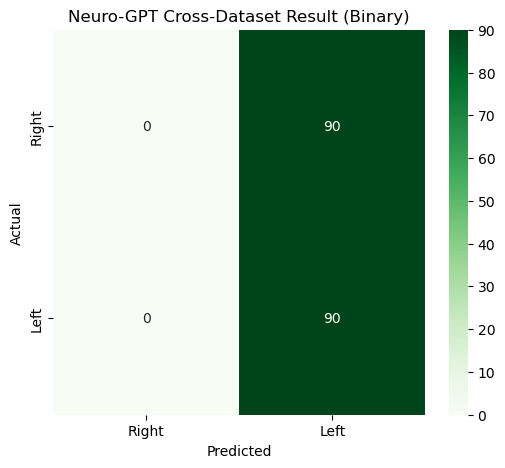

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define names based on your CLASS_MAP
target_names = ["Right Imagined", "Right Real", "Left Imagined", "Left Real"]

print("\n--- 4-Class Generalization Report ---")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Optional: Group into Binary (Right vs Left) as per your Abstract's goal
# Class 0,1 are Right | Class 2,3 are Left
binary_preds = [0 if p < 2 else 1 for p in all_preds]
binary_labels = [0 if l < 2 else 1 for l in all_labels]

print("\n--- Binary (Right vs Left) Report ---")
print(classification_report(binary_labels, binary_preds, target_names=["Right", "Left"]))

# Visualize the confusion
cm = confusion_matrix(binary_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Right", "Left"], yticklabels=["Right", "Left"])
plt.title("Neuro-GPT Cross-Dataset Result (Binary)")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()